# **Peach Disease Classification**

### **Loading the module and datas**

In [1]:
import tensorflow as tf
import keras
import numpy as np
from keras import layers, models
import matplotlib.pyplot as plt

In [2]:
#constants
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 15

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory="D:\Smart Farmer\Peach",
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 3575 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterial Spot', 'Healthy']

### **Data Visualization**

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0]


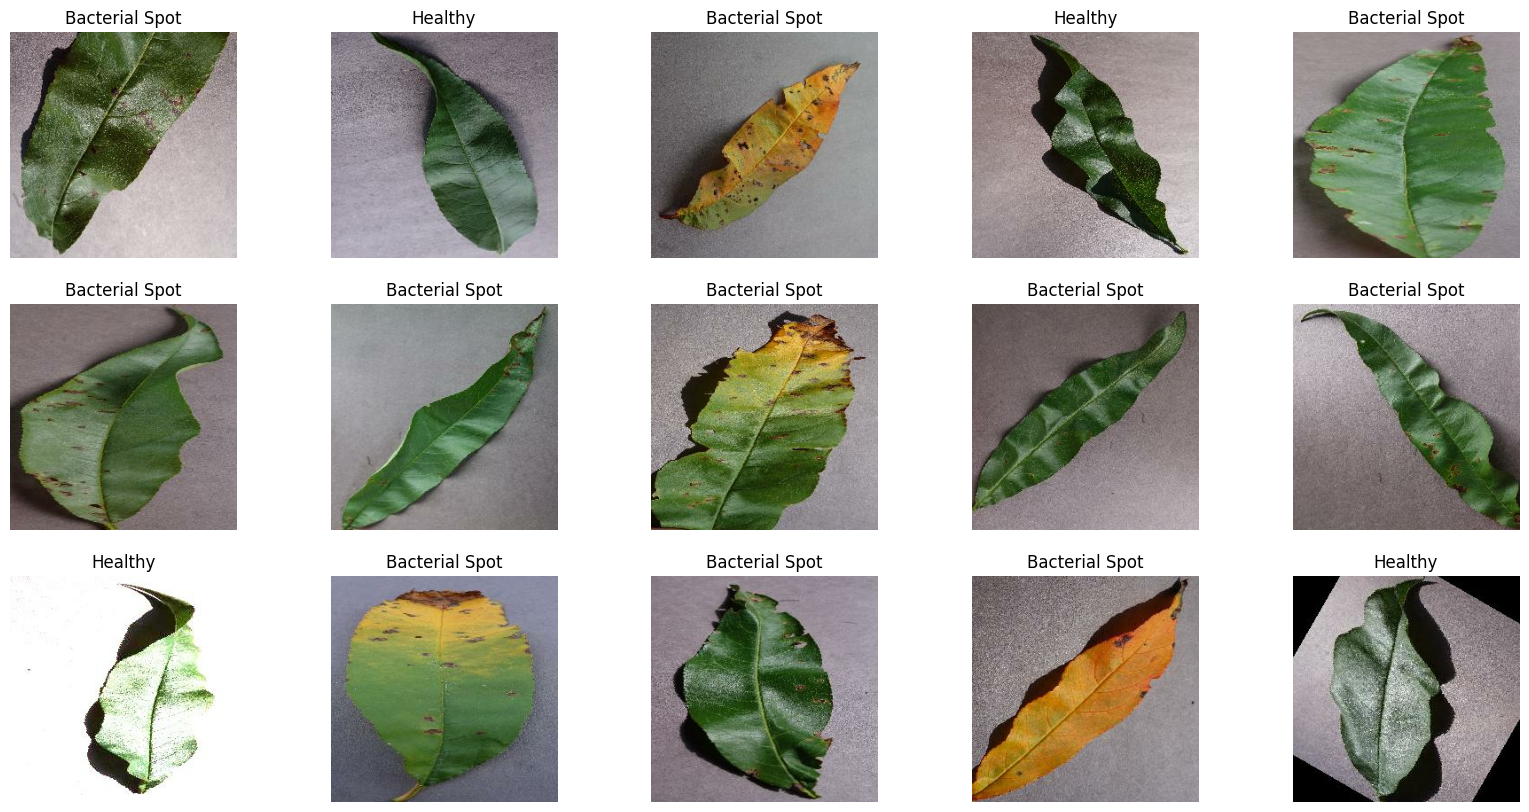

In [6]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### **Train Test Split**

In [7]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

  
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds ,test_ds, valid_ds
    

In [8]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)
    

In [9]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))

89
12
11


In [10]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### **Image Preprocessing**

In [11]:
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [12]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### **Building a Model**

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [15]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [16]:
#model training
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=EPOCHS
    
)

Epoch 1/15


89/89 [==============================] - 135s 982ms/step - loss: 0.2565 - accuracy: 0.8743 - val_loss: 0.1397 - val_accuracy: 0.9602
Epoch 2/15
89/89 [==============================] - 55s 622ms/step - loss: 0.1450 - accuracy: 0.9470 - val_loss: 0.0730 - val_accuracy: 0.9773
Epoch 3/15
89/89 [==============================] - 59s 660ms/step - loss: 0.1181 - accuracy: 0.9540 - val_loss: 0.1186 - val_accuracy: 0.9631
Epoch 4/15
89/89 [==============================] - 58s 654ms/step - loss: 0.1135 - accuracy: 0.9596 - val_loss: 0.0747 - val_accuracy: 0.9773
Epoch 5/15
89/89 [==============================] - 58s 652ms/step - loss: 0.0782 - accuracy: 0.9716 - val_loss: 0.0509 - val_accuracy: 0.9830
Epoch 6/15
89/89 [==============================] - 57s 642ms/step - loss: 0.0777 - accuracy: 0.9709 - val_loss: 0.0539 - val_accuracy: 0.9801
Epoch 7/15
89/89 [==============================] - 58s 653ms/step - loss: 0.0657 - accuracy: 0.9793 - val_loss: 0.0424 - val_accuracy: 0.9

In [17]:
model.save('peach.keras')

In [18]:
model = keras.models.load_model("D:\Smart Farmer\Peach\peach.keras")

In [19]:
scores = model.evaluate(test_ds)
scores

12/12 [==============================] - 88s 312ms/step - loss: 0.0694 - accuracy: 0.9760


[0.06937725096940994, 0.9760000109672546]

### **Plotting Model Accuracy**

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

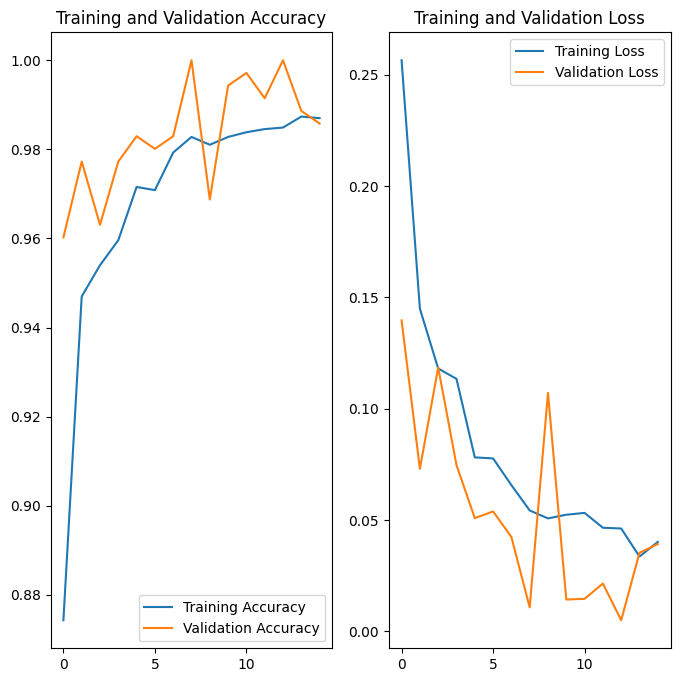

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Running prediction on a sample image**

first image to predict
actual label: Bacterial Spot
1/1 [==============================] - 17s 17s/step
predicted label: Bacterial Spot


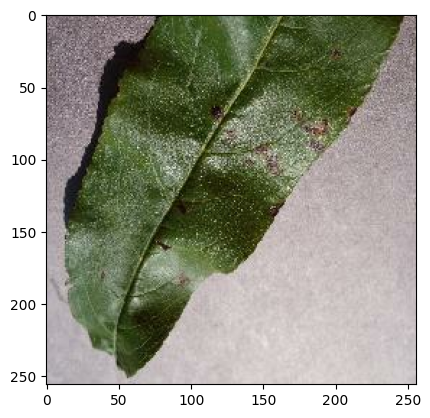

In [22]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
   
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break

### **Predictions**

In [24]:
def predict_peach_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
  

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


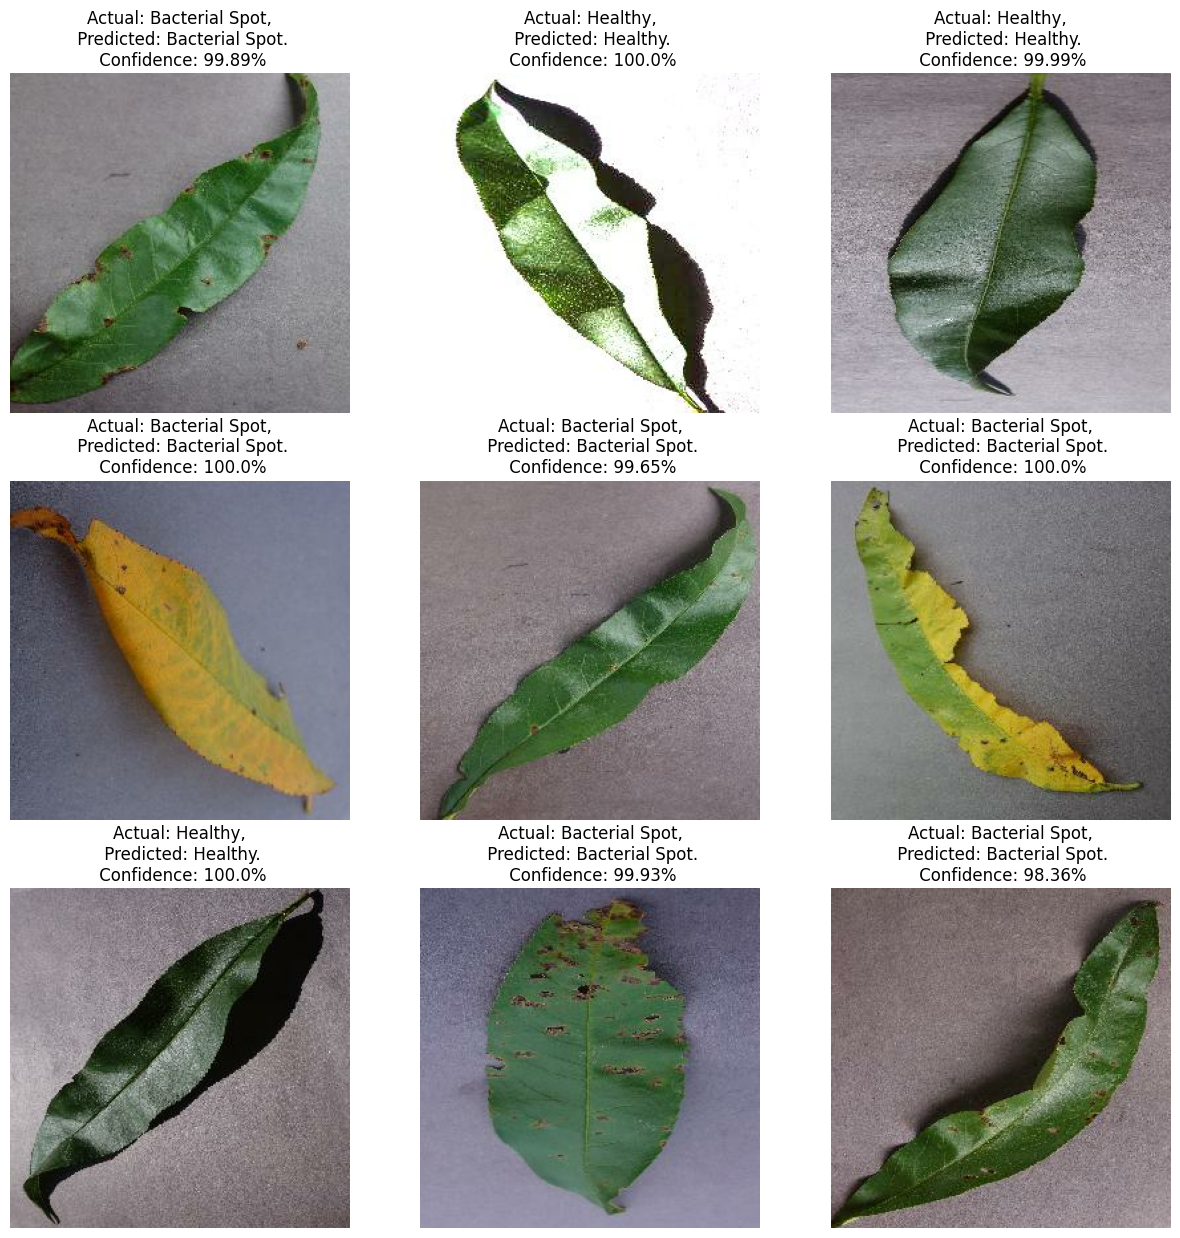

In [25]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_peach_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")